In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import base64
import csv
import os
import seaborn as sns
import numpy as np
from glob import glob
from shutil import copyfile

%matplotlib inline

pd.set_option('display.max_columns', 100)

In [3]:
df = pd.read_csv('dataset/recipes_df10-23-2017.csv', error_bad_lines=False, encoding='utf-8', sep = '\t')

In [4]:
len(set(df.recipe_id))
df.shape

(308562, 425)

In [5]:
df = df.dropna(axis=0, how='any')
df = df.drop_duplicates(subset = 'recipe_id')
# query recipes that were added less than 1 month
df = df.query('date_x < "2017-09-02"')

In [6]:
df.columns = [c.replace(' ', '_') for c in df.columns]

In [282]:
df['printed_total'] = np.exp(df['printed_per_day'])*df['days_exists']
df['printed_daily'] = df['printed_total']/df['days_exists']
df['log_printed_per_day'] = df['printed_per_day']

In [7]:
ing_cols = [col for col in df.columns if '_ing' in col]
tag_cols = [col for col in df.columns if '_tag' in col]
all_cols = df.columns.values.tolist()
rest_cols = set(all_cols) - set(ing_cols) - set(tag_cols)
#rest_cols

In [8]:
df_with_pics = df[df.has_picture == 'yes'].copy()

In [154]:
len(tag_cols)

167

In [9]:
id_v = 'recipe_id'
dv   = 'printed_per_day'

In [10]:
df_with_pics[[id_v, dv]].head()

,recipe_id,printed_per_day
2,recipe-3333651495007708,-1.533930
5,recipe-3333561494972170,-1.698233
11,recipe-3321081493152882,-1.159237
17,recipe-3205721477169720,-1.889821
19,recipe-3336321495482842,-0.739978


In [11]:
df_with_pics = df_with_pics.drop_duplicates(subset=[id_v, dv])

In [12]:
print(len(df_with_pics.recipe_id))
print(len(set(df_with_pics.recipe_id)))

182231
182231


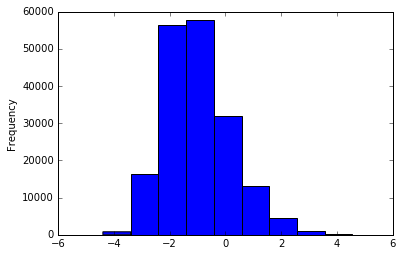

In [13]:
df_with_pics[dv].plot.hist()

In [16]:
df_with_pics['label'] = (df_with_pics[dv] >= df_with_pics[dv].quantile(q=0.5)).astype(str)
df_with_pics['label'].head()

2     False
5     False
11    False
17    False
19     True
Name: label, dtype: object

In [164]:
df_with_pics['new_name'] =  df_with_pics['label'] + '.' + df_with_pics['recipe_id'] + '.jpg'

In [165]:
df_with_pics.head()

,recipe_id,difficulty,date_x,has_picture,num_reviews,avg_rating,stars,prep_time,printed_total,printed_last_month,saved_total,saved_last_month,author_registered,author_posts,days_exists,author_reg,printed_per_day,saved_per_day,posts_per_day,Amaretto_ing,Ananas_ing,Apfel_ing,Apfelsaft_ing,Aprikose_ing,Aubergine_ing,Außerdem:_ing,Avocado_ing,Backpulver_ing,Bacon_ing,Balsamico_ing,Banane_ing,Bandnudeln_ing,Basilikum_ing,Birne_ing,Blattspinat_ing,Blumenkohl_ing,Blätterteig_ing,Bohnen_ing,Brokkoli_ing,Brötchen_ing,Brühe_ing,Butter_ing,Butter_oder_Margarine_ing,Buttermilch_ing,Butterschmalz_ing,Cayennepfeffer_ing,Champignons_ing,Chiliflocken_ing,Chilipulver_ing,Chilischote_ing,...,Schwein_tag,Schweiz_tag,Shake_tag,Silvester_tag,Skandinavien_tag,Snack_tag,Sommer_tag,Spanien_tag,Studentenküche_tag,Suppe_tag,Südafrika_tag,Süßspeise_tag,Tarte_tag,Thailand_tag,Torte_tag,Trennkost_tag,Tschechien_tag,Türkei_tag,USA_oder_Kanada_tag,Ungarn_tag,Vegan_tag,Vegetarisch_tag,Vietnam_tag,Vollwert_tag,Vorspeise_tag,Weihnachten_tag,Weißrussland_tag,Wild_tag,Wildgeflügel_tag,Winter_tag,Wok_tag,Wursten_tag,alkoholfrei_tag,cross-cooking_tag,einfach_tag,fettarm_tag,gebunden_tag,gekocht_tag,kalorienarm_tag,kalt_tag,klar_tag,marinieren_tag,raffiniert_oder_preiswert_tag,spezial_tag,warm_tag,Ägypten_tag,Österreich_tag,Überbacken_tag,label,new_name
2,recipe-3333651495007708,normal,2017-05-23,yes,1,3.00,3,45,33,0,0,0,2010-02-17,0,153,2805,-1.533930,-inf,-inf,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False.recipe-3333651495007708.jpg
5,recipe-3333561494972170,normal,2017-05-23,yes,1,3.00,3,25,28,0,1,0,2017-05-16,0,153,160,-1.698233,-5.030438,-inf,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,False,False.recipe-3333561494972170.jpg
11,recipe-3321081493152882,simpel,2017-05-23,yes,0,2.50,unb,10,48,2,0,0,2016-12-14,0,153,313,-1.159237,-inf,-inf,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,False,False.recipe-3321081493152882.jpg
17,recipe-3205721477169720,normal,2016-10-24,yes,0,2.50,unb,30,55,2,2,0,2013-06-02,0,364,1604,-1.889821,-5.204007,-inf,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,False,False.recipe-3205721477169720.jpg
19,recipe-3336321495482842,simpel,2017-05-23,yes,1,3.33,3_5,15,73,2,8,0,2014-10-05,518,153,1114,-0.739978,-2.950996,-0.765737,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,True,True.recipe-3336321495482842.jpg


In [14]:
np.exp(df[dv].quantile(q=0.5))

0.17522724870774797

In [15]:
np.exp(df_with_pics[dv].quantile(q=0.5))

0.31863354037267089

# Save pictures into folders with category in their names

In [ ]:
# rename search_pics to classification_with_pics2

In [158]:
#current_dir = os.getcwd()
#PROJECT_DIR = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences'
PROJECT_DIR  = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences'
PICTURES_DIR = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences\\classification_with_pics2'

In [22]:
%cd $PROJECT_DIR
#%mkdir classification_with_pics2
%mkdir classification_with_pics2\train
%mkdir classification_with_pics2\valid
%mkdir classification_with_pics2\sample
%mkdir classification_with_pics2\results
%mkdir classification_with_pics2\sample\train
%mkdir classification_with_pics2\sample\valid
%mkdir classification_with_pics2\sample\results

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences


In [159]:
%cd $PICTURES_DIR
#%mkdir classification_with_pics2
%mkdir train
%mkdir valid
%mkdir sample
%mkdir results
%mkdir sample\train
%mkdir sample\valid
%mkdir sample\results

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2


In [23]:
# Set pics folder as a working diretory
%cd $PICTURES_DIR

C:\Users\Natalia\Documents\GitHub\search_pics


In [160]:
g = glob('*.jpg')
g[:5]

['recipe-12972895612.jpg',
 'recipe-13972907778.jpg',
 'recipe-14972908306.jpg',
 'recipe-15972985893.jpg',
 'recipe-19972999410.jpg']

In [168]:
# made a renamed copy of pictures
# remove images without labels
nl = (set(g) - set(df_with_pics[id_v]+'.jpg'))
g = list(set(g) - set(nl))
for i in range(len(g)): os.rename(g[i], 
                               PICTURES_DIR
                               + "\\train\\" 
                               + df_with_pics[df_with_pics[id_v]+'.jpg' == g[i]]['new_name'].item())

In [166]:
df_with_pics[df_with_pics[id_v]+'.jpg' == g[1]]['new_name'].item()

'True.recipe-13972907778.jpg'

In [169]:
# Set train data folder as a working diretory
%cd $PICTURES_DIR\train\

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\train


In [170]:
# move 30k pictures from training set to validation set
g = glob('*.jpg')
shuf = np.random.permutation(g)
#for i in range(30000): os.rename(shuf[i]
for i in range(4): os.rename(shuf[i], 
                             PICTURES_DIR
                             + "\\valid\\"
                             + shuf[i])

In [171]:
# copy 200 images to sample set for experimentation
g = glob('*.jpg')
shuf = np.random.permutation(g)
#for i in range(200): copyfile(shuf[i], 
for i in range(5): copyfile(shuf[i],
                            PICTURES_DIR
                            +'\\sample\\train\\'
                            + shuf[i])

In [172]:
# Set validation data folder as a working diretory
%cd $PICTURES_DIR\valid\

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid


In [173]:
# copy 50 images from validation set to sample validation
g = glob('*.jpg')
shuf = np.random.permutation(g)
#for i in range(50): copyfile(shuf[i], 
for i in range(2): copyfile(shuf[i], 
                            PICTURES_DIR
                            +'\\sample\\valid\\' 
                            + shuf[i])

# Rearrange image files into their respective directories

In [41]:
#CLASSIFICATION_DIR = PROJECT_DIR +'\\classification_with_pics2'

In [174]:
#Divide cat/dog images into separate directories
%cd $PICTURES_DIR/sample/train
%mkdir popular
%mkdir unpopular
!move True.*.jpg popular/
!move False.*.jpg unpopular/

%cd $PICTURES_DIR/sample/valid
%mkdir popular
%mkdir unpopular
!move True.*.jpg popular/
!move False.*.jpg unpopular/

%cd $PICTURES_DIR/valid
%mkdir popular
%mkdir unpopular
!move True.*.jpg popular/
!move False.*.jpg unpopular/

%cd $PICTURES_DIR/train
%mkdir popular
%mkdir unpopular
!move True.*.jpg popular/
!move False.*.jpg unpopular/

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\True.recipe-13972907778.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\True.recipe-19972999410.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\True.recipe-30974460077.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\True.recipe-32974461094.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\train\True.recipe-34974726152.jpg
        5 file(s) moved.
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\valid


A duplicate file name exists, or the file
cannot be found.


C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\valid\True.recipe-28974106789.jpg
        1 file(s) moved.
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\sample\valid\False.recipe-36974792563.jpg
        1 file(s) moved.
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid\True.recipe-28974106789.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid\True.recipe-6971800010.jpg
        2 file(s) moved.
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid\False.recipe-12972895612.jpg
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2\valid\False.recipe-36974792563.jpg
        2 file(s) moved.
C:\Users\Natalia\Documents\GitHub\Extracting-food-preferen

# Finetune the VGG

In [175]:
os.getcwd()

'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences\\classification_with_pics2\\train'

In [176]:
%cd $PICTURES_DIR

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2


In [106]:
#import modules
from utils import *
from vgg16 import Vgg16
from datetime import datetime

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

In [65]:
#current_dir = os.getcwd()
#PROJECT_DIR = 'C:\\Users\\Natalia\\Documents\\GitHub\\Extracting-food-preferences'
#CLASSIFICATION_DIR = PROJECT_DIR +'\\classification_with_pics'

In [177]:
%cd $PICTURES_DIR

#Set path to sample/ path if desired
path = PICTURES_DIR + '\\sample'
#path = PICTURES_DIR + '\\' + 'sample\\'
results_path=path + '\\results\\'
train_path=path + '\\train\\'
valid_path=path + '\\valid\\'

C:\Users\Natalia\Documents\GitHub\Extracting-food-preferences\classification_with_pics2


In [178]:
#import Vgg16 helper class
vgg = Vgg16()

In [179]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=25
no_of_epochs=1

In [183]:
#Finetune the model
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.001

Found 5 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


In [184]:
start = datetime.now()
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print("Running epoch: {}".format(epoch))
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft{}.h5'.format(epoch)
    vgg.model.save_weights(results_path+latest_weights_filename)
print("Completed {} fit operations".format(no_of_epochs))
end = datetime.now()
total = end - start
print('Time to run the script on CPU is {}'.format(total))

Running epoch: 0
Epoch 1/1
5/5 [==============================] - 4s - loss: 0.1820 - acc: 1.0000 - val_loss: 3.8547 - val_acc: 0.5000
Completed 1 fit operations
Time to run the script on CPU is 0:00:11.159796


In [125]:
h=vgg.fit2(batches, val_batches, nb_epoch=5)

Epoch 1/5
200/200 [==============================] - 134s - loss: 3.6446 - acc: 0.6750 - val_loss: 4.9314 - val_acc: 0.6200
Epoch 2/5
200/200 [==============================] - 129s - loss: 3.5442 - acc: 0.6700 - val_loss: 4.6349 - val_acc: 0.5600
Epoch 3/5
200/200 [==============================] - 127s - loss: 2.2934 - acc: 0.7650 - val_loss: 4.3329 - val_acc: 0.6200
Epoch 4/5
200/200 [==============================] - 132s - loss: 2.4605 - acc: 0.7600 - val_loss: 4.4345 - val_acc: 0.5600
Epoch 5/5
200/200 [==============================] - 130s - loss: 2.1439 - acc: 0.7850 - val_loss: 4.1337 - val_acc: 0.6400


In [126]:
print(h.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


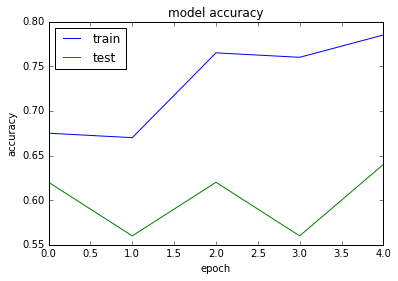

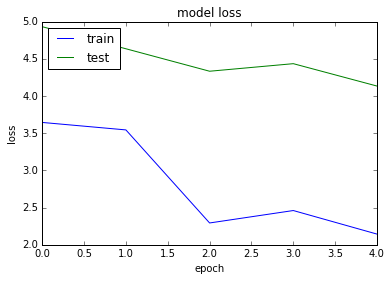

In [140]:
# summarize history for accuracy
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [128]:
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 50 images belonging to 2 classes.


In [129]:
filenames = val_batches.filenames
expected_labels = val_batches.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

In [130]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 32 correct labels


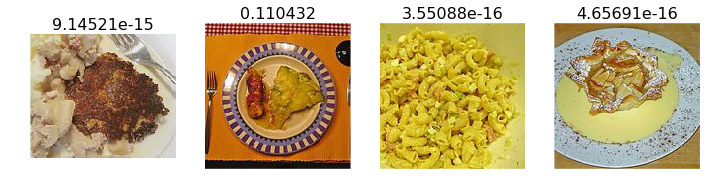

In [131]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print("Found {} correct labels".format(len(correct)))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 18 incorrect labels


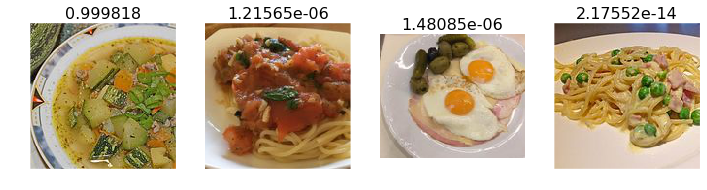

In [132]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print("Found {} incorrect labels".format(len(incorrect)))
#print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

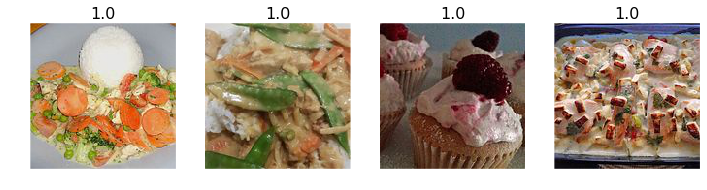

In [133]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
#print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

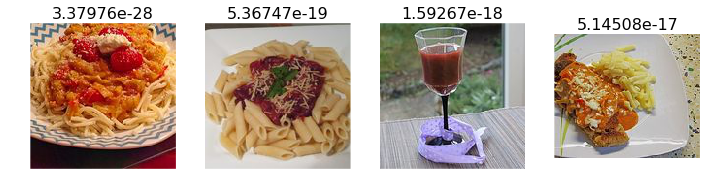

In [134]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
#print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

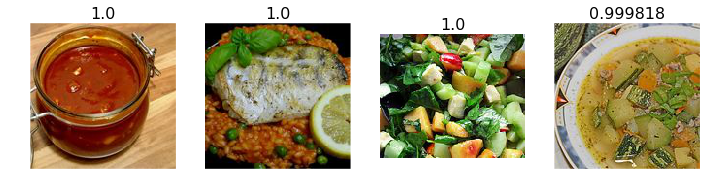

In [135]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
#print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

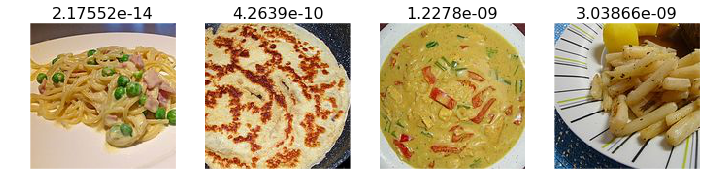

In [136]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
#print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

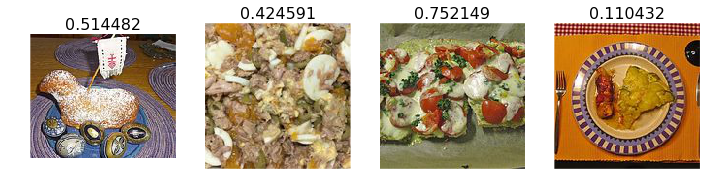

In [137]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

In [138]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[ 9 11]
 [ 7 23]]


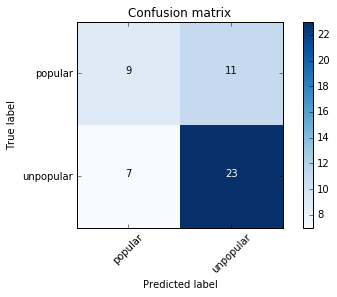

In [139]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [117]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

# In case we are going to use the TensorFlow backend we need to explicitly set the Theano image ordering
from keras import backend as K
K.set_image_dim_ordering('th')


vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr


class Vgg16():
    """
        The VGG 16 Imagenet model
    """


    def __init__(self):
        self.FILE_PATH = 'http://files.fast.ai/models/'
        self.create()
        self.get_classes()


    def get_classes(self):
        """
            Downloads the Imagenet classes index file and loads it to self.classes.
            The file is downloaded only if it not already in the cache.
        """
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

    def predict(self, imgs, details=False):
        """
            Predict the labels of a set of images using the VGG16 model.

            Args:
                imgs (ndarray)    : An array of N images (size: N x width x height x channels).
                details : ??
            
            Returns:
                preds (np.array) : Highest confidence value of the predictions for each image.
                idxs (np.ndarray): Class index of the predictions with the max confidence.
                classes (list)   : Class labels of the predictions with the max confidence.
        """
        # predict probability of each class for each image
        all_preds = self.model.predict(imgs)
        # for each image get the index of the class with max probability
        idxs = np.argmax(all_preds, axis=1)
        # get the values of the highest probability for each image
        preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
        # get the label of the class with the highest probability for each image
        classes = [self.classes[idx] for idx in idxs]
        return np.array(preds), idxs, classes


    def ConvBlock(self, layers, filters):
        """
            Adds a specified number of ZeroPadding and Covolution layers
            to the model, and a MaxPooling layer at the very end.

            Args:
                layers (int):   The number of zero padded convolution layers
                                to be added to the model.
                filters (int):  The number of convolution filters to be 
                                created for each layer.
        """
        model = self.model
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Convolution2D(filters, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))


    def FCBlock(self):
        """
            Adds a fully connected layer of 4096 neurons to the model with a
            Dropout of 0.5

            Args:   None
            Returns:   None
        """
        model = self.model
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))


    def create(self):
        """
            Creates the VGG16 network achitecture and loads the pretrained weights.

            Args:   None
            Returns:   None
        """
        model = self.model = Sequential()
        model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))

        self.ConvBlock(2, 64)
        self.ConvBlock(2, 128)
        self.ConvBlock(3, 256)
        self.ConvBlock(3, 512)
        self.ConvBlock(3, 512)

        model.add(Flatten())
        self.FCBlock()
        self.FCBlock()
        model.add(Dense(1000, activation='softmax'))

        fname = 'vgg16.h5'
        model.load_weights(get_file(fname, self.FILE_PATH+fname, cache_subdir='models'))


    def get_batches(self, path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        """
            Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)


    def ft(self, num):
        """
            Replace the last layer of the model with a Dense (fully connected) layer of num neurons.
            Will also lock the weights of all layers except the new layer so that we only learn
            weights for the last layer in subsequent training.

            Args:
                num (int) : Number of neurons in the Dense layer
            Returns:
                None
        """
        model = self.model
        model.pop()
        for layer in model.layers: layer.trainable=False
        model.add(Dense(num, activation='softmax'))
        self.compile()

    def finetune(self, batches):
        """
            Modifies the original VGG16 network architecture and updates self.classes for new training data.
            
            Args:
                batches : A keras.preprocessing.image.ImageDataGenerator object.
                          See definition for get_batches().
        """
        self.ft(batches.nb_class)
        classes = list(iter(batches.class_indices)) # get a list of all the class labels
        
        # batches.class_indices is a dict with the class name as key and an index as value
        # eg. {'cats': 0, 'dogs': 1}

        # sort the class labels by index according to batches.class_indices and update model.classes
        for c in batches.class_indices:
            classes[batches.class_indices[c]] = c
        self.classes = classes


    def compile(self, lr=0.001):
        """
            Configures the model for training.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.compile(optimizer=Adam(lr=lr),
                loss='categorical_crossentropy', metrics=['accuracy'])


    def fit_data(self, trn, labels,  val, val_labels,  nb_epoch=1, batch_size=64):
        """
            Trains the model for a fixed number of epochs (iterations on a dataset).
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.fit(trn, labels, nb_epoch=nb_epoch,
                validation_data=(val, val_labels), batch_size=batch_size)


    def fit(self, batches, val_batches, nb_epoch=1):
        """
            Fits the model on data yielded batch-by-batch by a Python generator.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

    def fit2(self, batches, val_batches, nb_epoch=1):
        """
            Fits the model on data yielded batch-by-batch by a Python generator.
            See Keras documentation: https://keras.io/models/model/
        """
        history = self.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
        return history
        
    def test(self, path, batch_size=8):
        """
            Predicts the classes using the trained model on data yielded batch-by-batch.

            Args:
                path (string):  Path to the target directory. It should contain one subdirectory 
                                per class.
                batch_size (int): The number of images to be considered in each batch.
            
            Returns:
                test_batches, numpy array(s) of predictions for the test_batches.
    
        """
        test_batches = self.get_batches(path, shuffle=False, batch_size=batch_size, class_mode=None)
        return test_batches, self.model.predict_generator(test_batches, test_batches.nb_sample)

